Title: **Assignment 2 - COSC3013 Computational Machine Learning - End-to-end Machine Learning Project**

Student ID: **S3979613**

Student Name and email (contact info): **Dao Sy Trung Kien - S3979613@rmit.edu.vn**

Affiliations: **RMIT University Vietnam.**

Date of Report: 03/08/2023

I certify that this is all my own original work. If I took any parts from elsewhere, then they were non-essential parts of the assignment, and they are clearly attributed in my submission.  I will show I agree to this honor code by typing "Yes": Yes.

Please start your report here. 

### Required Libraries and Utilities

In [1]:
# Importing packages - Pandas, Numpy, Seaborn, Scipy, Impute
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
np.random.seed(0)
from sklearn.impute import SimpleImputer

# Modelling
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Oversampling
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')
pd.options.display.max_rows = 4000

### Import data and check for null values.

In [2]:
# Code for import data from Paitients_Files_Train csv file
df_train = pd.read_csv('UCI_data.csv')
# Print out data.
df_train.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
0,2016-04-19 20:30:00,22.200000,39.500000,20.566667,37.656667,22.230000,37.030000,22.318571,36.610000,20.633333,...,33.90,9.70,766.100000,65.5,3.500000,40.000000,3.350000,24.061869,24.061869,60
1,2016-03-05 04:40:00,20.356667,37.126667,17.566667,40.230000,20.890000,37.663333,18.700000,36.260000,18.463333,...,41.09,0.30,740.333333,99.0,1.000000,41.333333,0.100000,4.622052,4.622052,50
2,2016-03-14 12:40:00,20.926667,38.790000,21.100000,35.526667,21.600000,36.290000,21.000000,34.826667,18.100000,...,38.76,4.40,768.466667,72.0,6.000000,22.666667,-0.266667,5.635898,5.635898,80
3,2016-01-22 15:30:00,18.290000,38.900000,17.290000,39.260000,18.390000,39.326667,16.100000,38.790000,16.100000,...,39.20,3.35,760.600000,82.0,5.500000,41.000000,0.500000,49.216445,49.216445,40
4,2016-02-10 00:40:00,22.290000,42.333333,21.600000,40.433333,22.666667,43.363333,19.100000,40.900000,19.290000,...,43.73,3.20,738.900000,88.0,7.333333,56.000000,1.400000,47.617579,47.617579,60


In [3]:
# Calculating the Missing Values % contribution in Train Data
df_train_null = round(100*(df_train.isnull().sum())/len(df_train), 2)
df_train_null

date             0.0
T1               0.0
RH_1             0.0
T2               0.0
RH_2             0.0
T3               0.0
RH_3             0.0
T4               0.0
RH_4             0.0
T5               0.0
RH_5             0.0
T6               0.0
RH_6             0.0
T7               0.0
RH_7             0.0
T8               0.0
RH_8             0.0
T9               0.0
RH_9             0.0
T_out            0.0
Press_mm_hg      0.0
RH_out           0.0
Windspeed        0.0
Visibility       0.0
Tdewpoint        0.0
rv1              0.0
rv2              0.0
TARGET_energy    0.0
dtype: float64

### Basic Data Exploration.

In [4]:
# Check the dimensions of the Training dataset
print(df_train.shape)

(19735, 28)


In [5]:
# Get info of the dataframe columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19735 non-null  object 
 1   T1             19735 non-null  float64
 2   RH_1           19735 non-null  float64
 3   T2             19735 non-null  float64
 4   RH_2           19735 non-null  float64
 5   T3             19735 non-null  float64
 6   RH_3           19735 non-null  float64
 7   T4             19735 non-null  float64
 8   RH_4           19735 non-null  float64
 9   T5             19735 non-null  float64
 10  RH_5           19735 non-null  float64
 11  T6             19735 non-null  float64
 12  RH_6           19735 non-null  float64
 13  T7             19735 non-null  float64
 14  RH_7           19735 non-null  float64
 15  T8             19735 non-null  float64
 16  RH_8           19735 non-null  float64
 17  T9             19735 non-null  float64
 18  RH_9  

### Data Pre-processing.

In [6]:
# Kien's removing outliers method
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
Q1 = df_train.select_dtypes(include=[float, int]).quantile(0.25)
Q3 = df_train.select_dtypes(include=[float, int]).quantile(0.75)

# Calculate IQR for each column
IQR = Q3 - Q1

# Determine the lower and upper caps
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR

# Create a boolean mask for rows within the lower and upper caps
mask = ((df_train.select_dtypes(include=[float, int]) >= lower_cap) & 
        (df_train.select_dtypes(include=[float, int]) <= upper_cap)).all(axis=1)

# Filter the DataFrame using the mask
df_train_filtered = df_train[mask]

In [7]:
# # Nhan's removing outliers method
# from scipy import stats
# # Filter the DataFrame
# df_train_filtered = df_train.drop(['date'], axis=1)
# # Calculate Z-scores for each column
# z_scores = stats.zscore(df_train_filtered.select_dtypes(include=[float, int]))
# # Calculate Z-scores for each numerical feature
# z_scores = np.abs(stats.zscore(df_train_filtered))
# outliers = np.where(z_scores > 3)  # Identify points more than 3 standard deviations away
# # Calculate IQR(measure of data statistical dispersion) for each numerical feature
# Q1 = df_train_filtered.quantile(0.25)
# Q3 = df_train_filtered.quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# # outliers = ((df_train_filtered < (lower_bound)) | (df_train_filtered > (upper_bound))).sum()
# # print(outliers)
# # Cap and floor the outliers
# for feature in df_train_filtered:
#     lower_cap = Q1[feature] - 1.5 * IQR[feature]
#     upper_cap = Q3[feature] + 1.5 * IQR[feature]
#     df_train_filtered[feature] = np.where(df_train_filtered[feature] < lower_cap, lower_cap, df_train_filtered[feature])
#     df_train_filtered[feature] = np.where(df_train_filtered[feature] > upper_cap, upper_cap, df_train_filtered[feature])

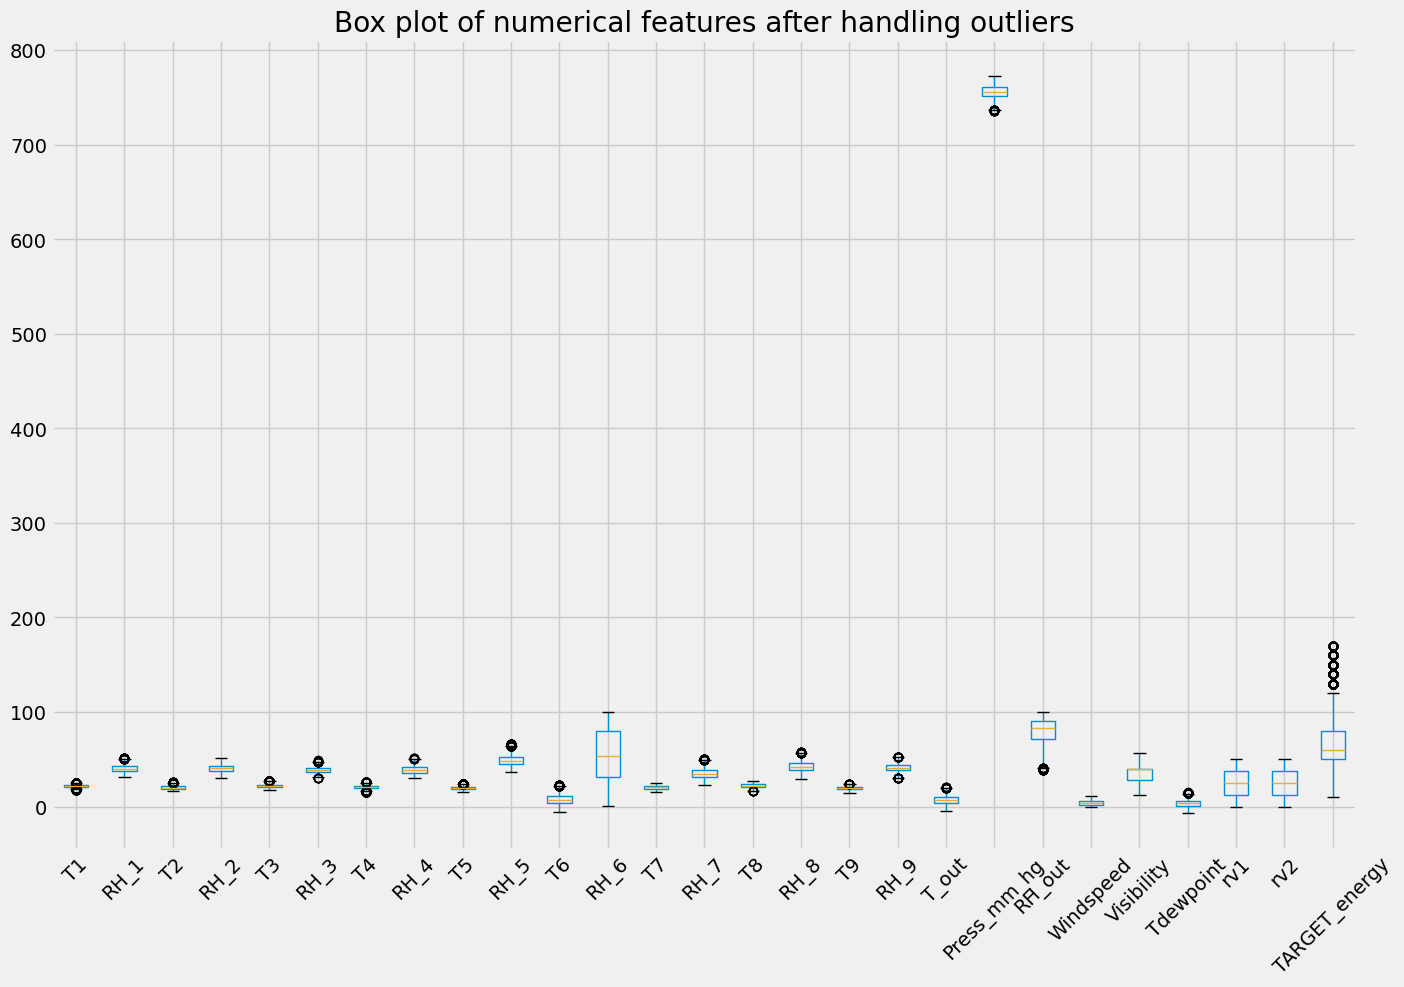

In [8]:
# Kien's version remove upper outliers
plt.figure(figsize=(15, 10))
df_train_filtered.boxplot()
plt.title('Box plot of numerical features after handling outliers')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Add date column for further analysis
df_train_filtered.loc[:, "date"] = df_train['date']

### Feature Engineering.

In [11]:
# Calculate the median of the Windspeed column
median_windspeed = df_train_filtered['Windspeed'].median()
# Replace missing values with median
df_train_filtered['Windspeed'].replace(0, median_windspeed, inplace=True)

In [12]:
# Convert the datetime column to a pandas datetime object
df_train_filtered['datetime'] = pd.to_datetime(df_train_filtered['date'])

# Create new columns for date and time
df_train_filtered['date'] = df_train_filtered['datetime'].dt.date
df_train_filtered['time'] = df_train_filtered['datetime'].dt.time

#Hour of the Day
df_train_filtered['hour'] = df_train_filtered['datetime'].dt.hour

# Day Part
df_train_filtered['day_part'] = pd.cut(df_train_filtered['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

# Season
df_train_filtered['month'] = df_train_filtered['datetime'].dt.month
df_train_filtered['season'] = df_train_filtered['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')

# Drop the original datetime column if no longer needed
df_train_filtered.drop('datetime', axis=1, inplace=True)

In [13]:
# Encode the 'day_part' categorical feature into numerical values
df_train_filtered['day_part_encoded'] = df_train_filtered['day_part'].cat.codes

In [14]:
#Get the mean of TARGET_energy for each 3 hours and 24 hours
df_train_filtered['moving_avg_3_hours'] = df_train_filtered['TARGET_energy'].rolling(window=3).mean()
df_train_filtered['moving_avg_24_hours'] = df_train_filtered['TARGET_energy'].rolling(window=24).mean()

In [15]:
#Get the total TARGET_energy of a day 
df_train_filtered['datetime'] = pd.to_datetime(df_train_filtered['date'])
df_train_filtered['daily_total_usage'] = df_train_filtered.groupby(df_train_filtered['datetime'].dt.date)['TARGET_energy'].transform('sum')
df_train_filtered.drop('datetime', axis=1, inplace=True)

In [16]:
#The difference between TARGET_energy in this day at this time with the next day.
df_train_filtered['rate_of_change_day'] = df_train_filtered['TARGET_energy'].diff(periods=24)
#The difference between TARGET_energy in this day at this time with the next 3 hours.
df_train_filtered['rate_of_change_3_hours'] = df_train_filtered['TARGET_energy'].diff(periods=3)


In [17]:
#Because these apply on the first 3 and 24 rows so I turn it to zero
df_train_filtered['rate_of_change_day'].fillna(0, inplace=True)
df_train_filtered['moving_avg_3_hours'].fillna(0, inplace=True)
df_train_filtered['moving_avg_24_hours'].fillna(0, inplace=True)
df_train_filtered['rate_of_change_3_hours'].fillna(0, inplace=True)

In [18]:
season_to_number = {
    "Spring": 1,
    "Summer": 2,
    "Fall": 3,
    "Winter": 4
}
df_train_filtered['season_encoded'] = df_train_filtered['season'].map(season_to_number)

In [19]:
temperature_columns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']
df_train_filtered['temperature_mean'] = df_train_filtered[temperature_columns].mean(axis=1)

In [20]:
humidity_columns = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']
df_train_filtered['humidity_mean'] = df_train_filtered[humidity_columns].mean(axis=1)

In [21]:
# df_train_filtered['daylight'] = df_train_filtered['hour'].between(6,18)
# df_train_filtered['daylight'] = np.where(df_train_filtered['daylight'], 1, 0)

#Get the accurate daylight (sunrise) based on the time in Belgium
daylight_hours = {
    (12, 1, 2): (9, 16),  # Winter: 9 AM to 4 PM
    (3, 4, 5): (7, 19),   # Spring: 7 AM to 7 PM
    (6, 7, 8): (6, 21),   # Summer: 6 AM to 9 PM
    (9, 10, 11): (7, 18)  # Fall: 7 AM to 6 PM
}

def is_daylight(row):
    month = row['month']
    hour = row['hour']
    for months, hours in daylight_hours.items():
        if month in months:
            return 1 if hours[0] <= hour <= hours[1] else 0

# Apply the function to create the 'daylight' column
df_train_filtered['daylight'] = df_train_filtered.apply(is_daylight, axis=1)

In [22]:
df_train_filtered['weather'] = df_train_filtered['T_out'].apply(lambda x: 'normal' if x > 5 else 'cold')
df_train_filtered['weather_encoded'] = np.where(df_train_filtered['weather'] == 'normal', 0, 1)

(array([   5.,  230.,    0.,  499.,    0., 1414.,    0., 3236.,    0.,
        2279.,    0., 1093.,    0.,  933.,    0.,  780.,  659.,    0.,
         541.,    0.,  410.,    0.,  281.,    0.,  174.,    0.,  136.,
           0.,  124.,   68.]),
 array([ 10.        ,  15.33333333,  20.66666667,  26.        ,
         31.33333333,  36.66666667,  42.        ,  47.33333333,
         52.66666667,  58.        ,  63.33333333,  68.66666667,
         74.        ,  79.33333333,  84.66666667,  90.        ,
         95.33333333, 100.66666667, 106.        , 111.33333333,
        116.66666667, 122.        , 127.33333333, 132.66666667,
        138.        , 143.33333333, 148.66666667, 154.        ,
        159.33333333, 164.66666667, 170.        ]),
 <BarContainer object of 30 artists>)

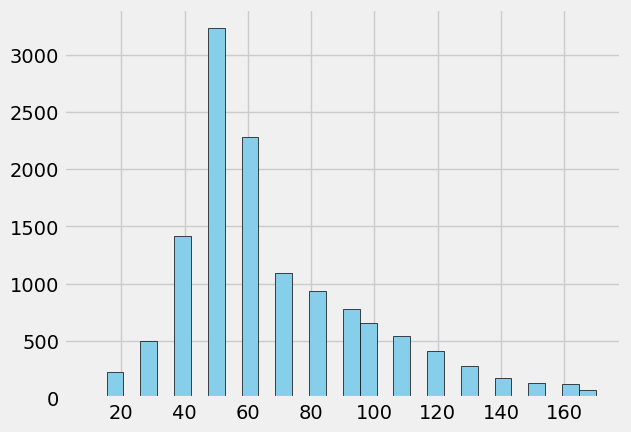

In [23]:
#Check on the TARGET_energy is there any skewed on the dataset (Kien's version)
plt.hist(df_train_filtered['TARGET_energy'], bins=30, color='skyblue', edgecolor='black')

In [24]:
# #Check on the TARGET_energy is there any skewed on the dataset (Nhan's version)
# plt.hist(df_train_filtered['TARGET_energy'], bins=30, color='skyblue', edgecolor='black')

### Correlation Matrix

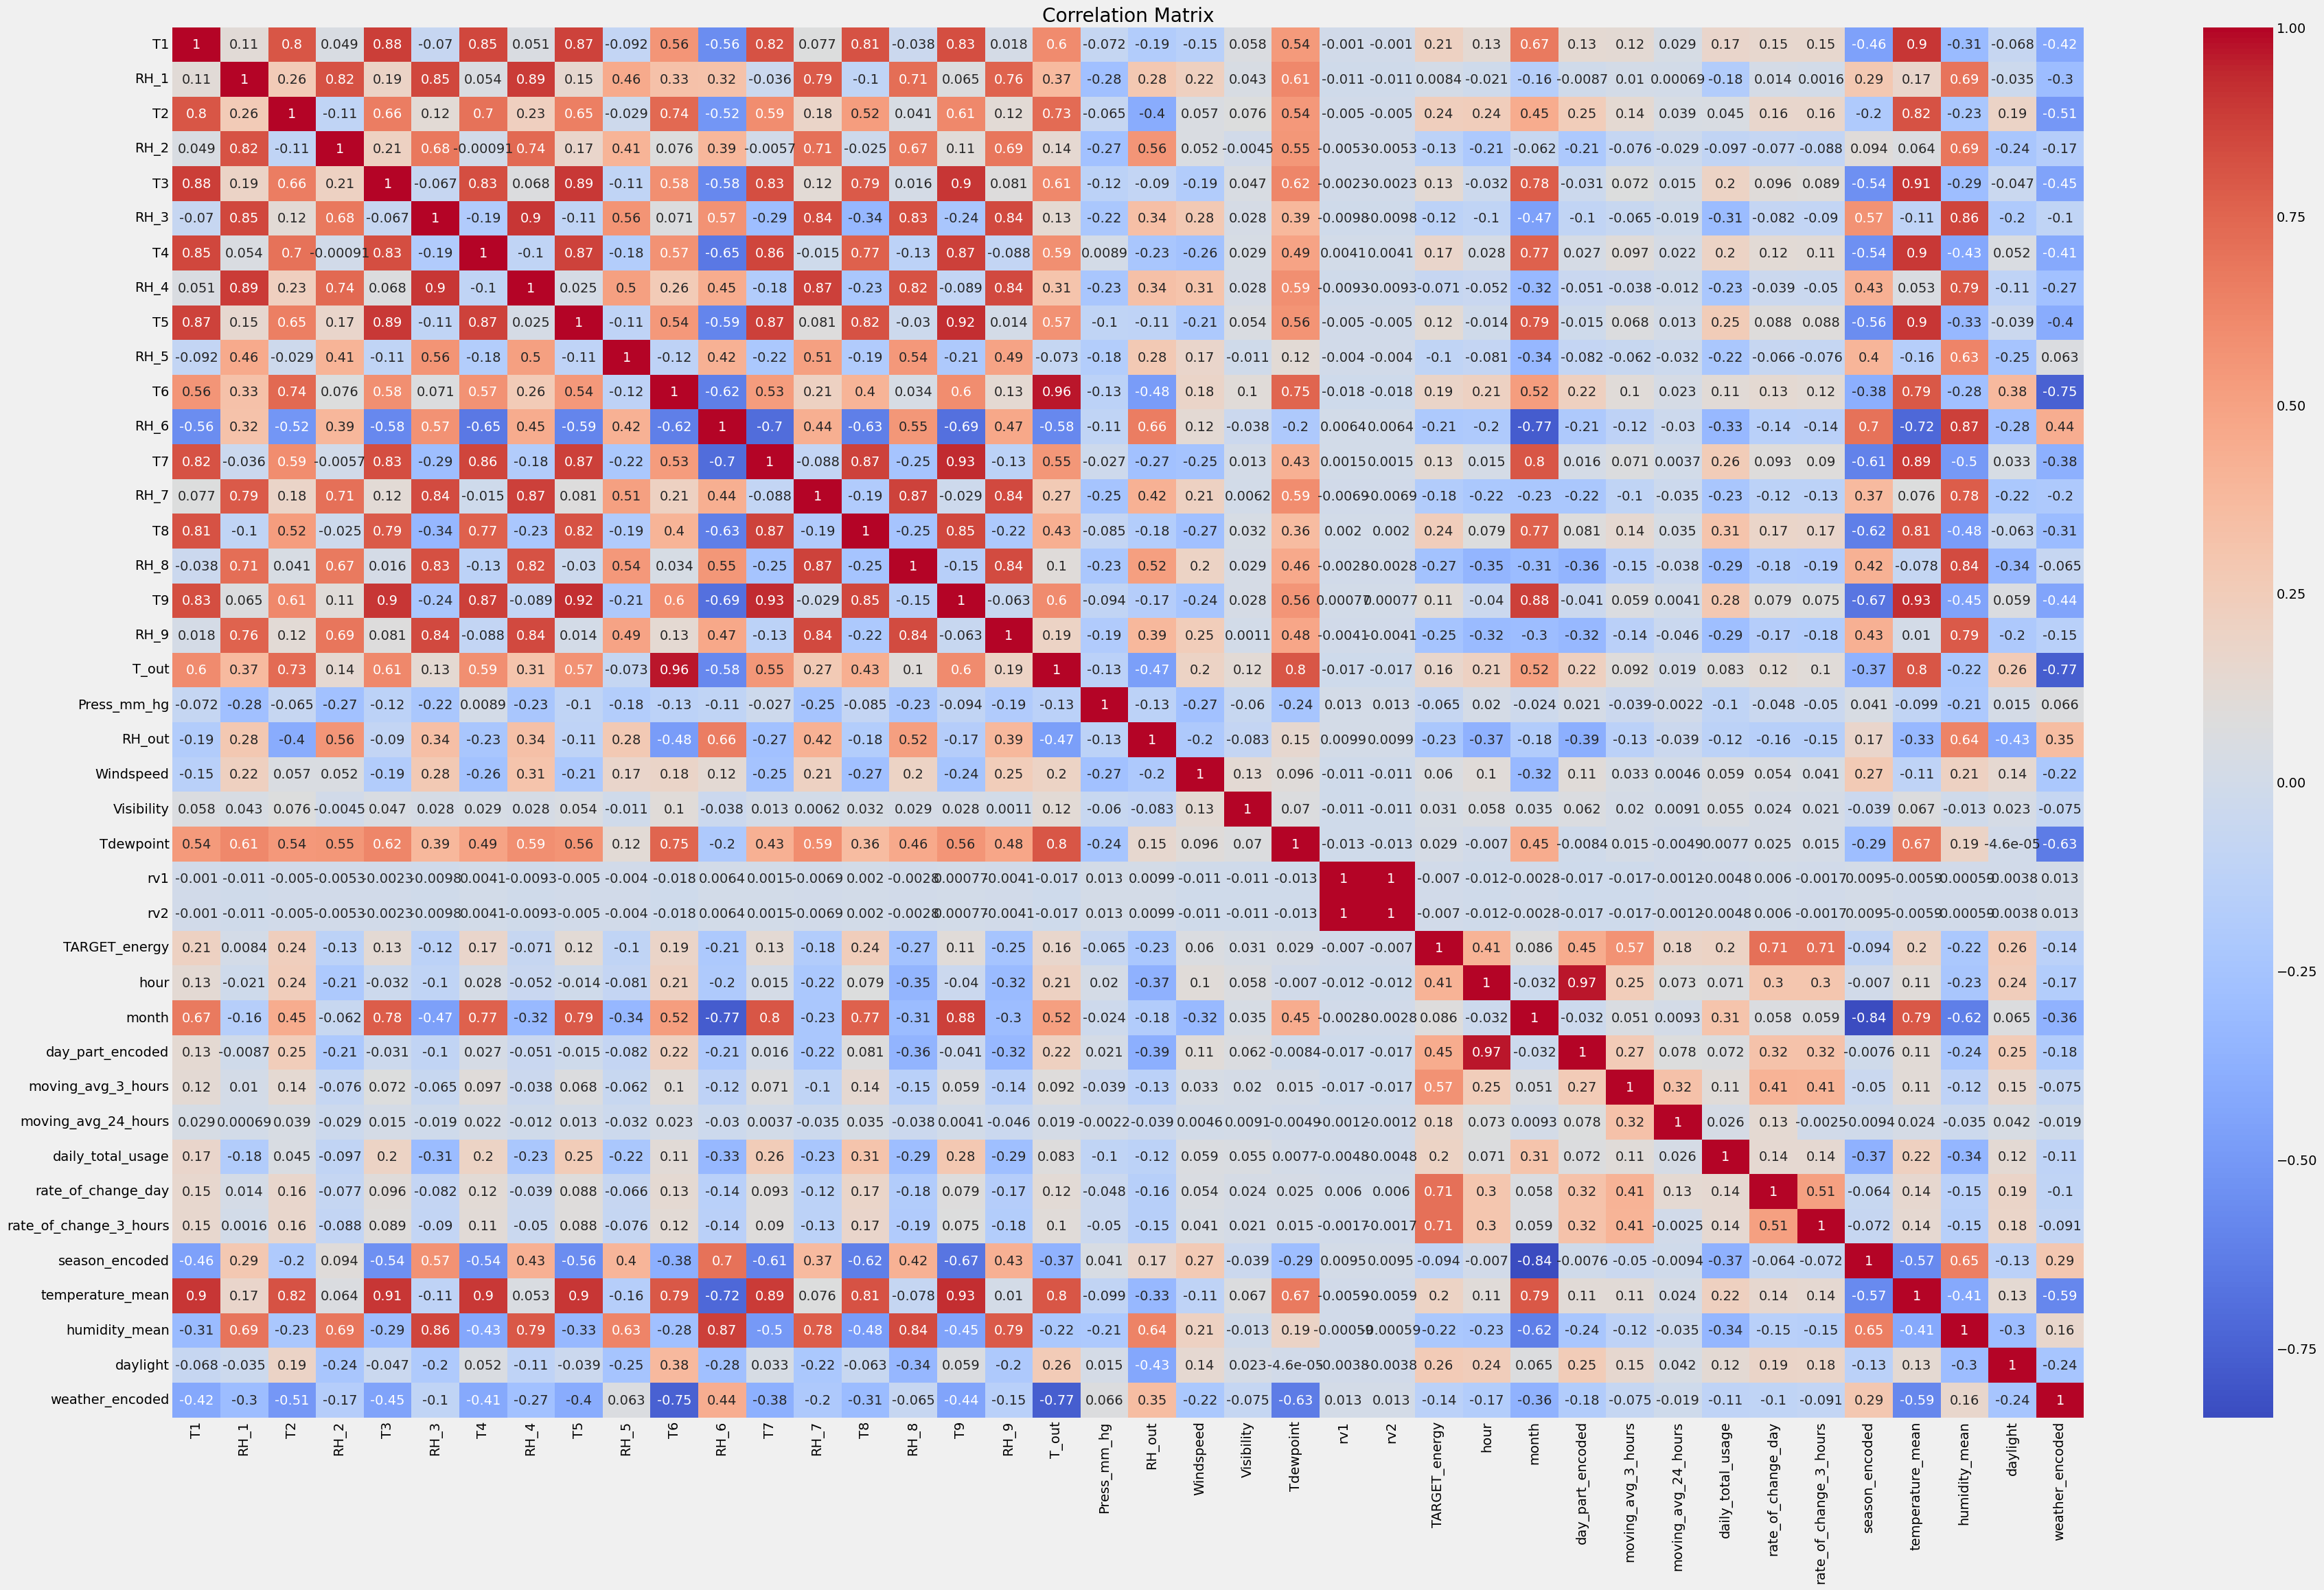

In [25]:
# Correlation Matrix after removing outliers (Kien's version)
numeric_df_train = df_train_filtered.select_dtypes(include=[np.number])
plt.figure(figsize=(40, 25))
sns.heatmap(numeric_df_train.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### Data spliting without smote

In [27]:
# Feature Selection
X = df_train_filtered[['temperature_mean', 'humidity_mean', 'hour', 'day_part_encoded', 'daylight', 'season_encoded', 'weather_encoded', 'Windspeed', 'Visibility', 'Tdewpoint','rate_of_change_day', 'moving_avg_3_hours', 'moving_avg_24_hours', 'rate_of_change_3_hours', 'daily_total_usage']]
y = df_train_filtered['TARGET_energy']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, shuffle=True)

### Data spliting with smote

In [28]:
# Feature Selection
X = df_train_filtered[['temperature_mean', 'humidity_mean', 'hour', 'day_part_encoded', 'daylight', 'season_encoded', 'weather_encoded', 'Windspeed', 'Visibility', 'Tdewpoint','rate_of_change_day', 'moving_avg_3_hours', 'moving_avg_24_hours', 'rate_of_change_3_hours', 'daily_total_usage']]
y = df_train_filtered['TARGET_energy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

# Apply SMOTE to the training data with k_neighbors set to 2
smote = SMOTE(sampling_strategy='minority', k_neighbors=2, random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb

# # Define the models and their hyperparameter grids
models = {
    # 'LinearRegression': {
    #     'model': LinearRegression(),
    #     'params': {  
    #         'fit_intercept':[True , False], 
    #         'n_jobs':[None, -1, 1],            
    #         'positive':[False, True]    
    #     }       
    # },
    # 'Ridge': {
    #     'model': Ridge(random_state=0),
    #     'params': {
    #         'alpha': [0.01, 0.1, 1, 10, 100]
    #     }
    # },
    # 'Lasso': {
    #     'model': Lasso(random_state=0),
    #     'params': {
    #         'alpha': [0.01, 0.1, 1, 10, 100]
    #     }
    # },
    # 'ElasticNet': {
    #     'model': ElasticNet(),
    #     'params': {
    #         'alpha': [0.01, 0.1, 1, 10, 100],
    #         'l1_ratio': [0.1, 0.5, 0.7, 1.0]
    #     }
    # },
    # 'DecisionTreeRegressor': {
    #     'model': DecisionTreeRegressor(random_state=0),
    #     'params': {
    #         'max_depth': [None, 10, 20, 30],
    #         'min_samples_split': [2, 5, 10]
    #     }
    # },
    # 'KNeighborsRegressor': {
    #     'model': KNeighborsRegressor(),
    #     'params': {
    #         'n_neighbors': [3, 5, 7, 9],
    #         'weights': ['uniform', 'distance']
    #     }
    # },
    # 'AdaBoostRegressor': {
    #     'model': AdaBoostRegressor(random_state=0),
    #     'params': {
    #         'n_estimators': [50, 100, 200],
    #         'learning_rate': [0.01, 0.1, 0.2]
    #     }
    # },
    # 'SVR': {
    #     'model': SVR(),
    #     'params': {
    #         'C': [0.1, 1, 10],
    #         'epsilon': [0.01, 0.1, 0.2],
    #         'kernel': ['linear', 'rbf']
    #     }
    # },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=0),
        'params': {
            'n_estimators': [500 , 1000],
            'max_depth': [None, 30],
            'max_features': ['sqrt'],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'bootstrap': [True],
            'oob_score': [True],
            'warm_start': [True]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=0),
        'params': {
            'n_estimators': [500, 1000],
            'learning_rate': [0.01],
            'max_depth': [6, 7],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'subsample': [0.9],
            'loss': ['huber', 'quantile'],
            'max_features': ['sqrt', 'log2']
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(random_state=0),
        'params': {
            'n_estimators': [500, 1000],
            'learning_rate': [0.01],
            'max_depth': [6, 7],
            'subsample': [0.8, 0.9],
        }
    },
    'LightGBM': {
        'model': lgb.LGBMRegressor(random_state=0, force_col_wise=True),
        'params': {
            'n_estimators': [500, 1000],
            'learning_rate': [0.01],
            'max_depth': [-1, 20],
            'num_leaves': [150],
            'subsample': [0.8, 0.9],
            'boosting_type': ['gbdt'],
            'reg_alpha': [0.1],
            'reg_lambda': [1, 1.5],
            'feature_fraction': [0.8],
        }
    },
    'MLPRegressor': {
        'model': MLPRegressor(random_state=0),
        'params': {
            'hidden_layer_sizes': [(100, 100)],
            'activation': ['relu'],
            'solver': ['adam'],
            'alpha': [ 0.0001],
            'learning_rate': ['constant'],
            'learning_rate_init': [ 0.0001],
            'max_iter': [500],
            'early_stopping': [True]
        }
    }
}

### Nomal models for Training with smote

In [30]:
# # Perform each model fitting on X_train, y_train
# for model_detail in models:
#     model = models[model_detail]['model']
#     # Make predictions on the testing set
#     model.fit(X_train_resampled_scaled, y_train_resampled)
#     y_pred = model.predict(X_test_scaled)
#     # Evaluate the model's performance
#     # mse = mean_squared_error(y_test, y_pred)
#     # rmse = mean_squared_error(y_test, y_pred, squared=False)
#     r2 = r2_score(y_test, y_pred)
#     # print(f'Mean Squared Error: {mse}')
#     # print(f'Root Mean Squared Error: {rmse}')
#     print(f'Model: {model}')
#     print(f'R^2 Score: {r2}')
#     # Cross-validation
#     cv_scores = cross_val_score(model, X_train_resampled_scaled, y_train_resampled, cv=5, scoring='neg_mean_squared_error')
#     cv_rmse = np.sqrt(-cv_scores)
#     print(f'Cross-validated MSE: {-cv_scores.mean()}')
#     print(f'Cross-validated RMSE: {cv_rmse.mean()}')
#     print('')

### Normal models for Training without smote

In [37]:
# Perform each model fitting on X_train, y_train
for model_detail in models:
    model = models[model_detail]['model']
    # Make predictions on the testing set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f'Model: {model}')
    print(f'R^2 Score: {r2}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    # Cross-validation
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    print(f'Cross-validated MSE: {-cv_scores.mean()}')
    print(f'Cross-validated RMSE: {cv_rmse.mean()}')
    print('')

Model: RandomForestRegressor(random_state=0)
R^2 Score: 0.8501183624312552
Mean Squared Error: 139.94373931070226
Root Mean Squared Error: 11.829781879252984
Cross-validated MSE: 137.19996286263805
Cross-validated RMSE: 11.710823732364439

Model: GradientBoostingRegressor(random_state=0)
R^2 Score: 0.854865873515847
Mean Squared Error: 135.51101183071296
Root Mean Squared Error: 11.64091971584346
Cross-validated MSE: 135.4197914942914
Cross-validated RMSE: 11.63617844339275

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, ma

### Find best param for each model based on R2 score

In [63]:
# Perform grid search for each model fitting on X_train, y_train
best_params = {}
best_scores = {}
for model_detail in models:
    model = models[model_detail]['model']
    param_grid = models[model_detail]['params']
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_params[model_detail] = grid_search.best_params_
    best_scores[model_detail] = grid_search.best_score_
    print(f'{model_detail} best params: {grid_search.best_params_}')
    print(f'{model_detail} best r2 score: {grid_search.best_score_:.4f}')
    print('')

Fitting 10 folds for each of 4 candidates, totalling 40 fits
RandomForestRegressor best params: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'oob_score': True, 'warm_start': True}
RandomForestRegressor best r2 score: 0.8528

Fitting 10 folds for each of 16 candidates, totalling 160 fits
GradientBoostingRegressor best params: {'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'subsample': 0.9}
GradientBoostingRegressor best r2 score: 0.8556

Fitting 10 folds for each of 8 candidates, totalling 80 fits
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.8}
XGBoost best r2 score: 0.8572

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting

In [33]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

### Data Modeling

### Linear Regression model

In [ ]:
# Feature Selection
X = df_train_filtered[['temperature_mean', 'humidity_mean', 'hour', 'day_part_encoded', 'daylight', 'season_encoded', 'weather_encoded', 'Windspeed', 'Visibility', 'Tdewpoint','rate_of_change_day', 'moving_avg_3_hours', 'moving_avg_24_hours', 'rate_of_change_3_hours', 'daily_total_usage']]
y = df_train_filtered['TARGET_energy']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, shuffle=True)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated MSE: {-cv_scores.mean()}')
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

Mean Squared Error: 661.0428887819321
Root Mean Squared Error: 25.710754340974365
R^2 Score: 0.30791213614930424
Cross-validated MSE: 618.0300147072985
Cross-validated RMSE: 24.855180758466343


### Random Forest model

In [ ]:
# Feature Selection
X = df_train_filtered[['temperature_mean', 'humidity_mean', 'hour', 'day_part_encoded', 'daylight', 'season_encoded', 'weather_encoded', 'Windspeed', 'Visibility', 'Tdewpoint']]
y = df_train_filtered['TARGET_energy']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, shuffle=True)

# Initialize and train the Random Forest model
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated MSE: {-cv_scores.mean()}')
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

Mean Squared Error: 300.17973571706176
Root Mean Squared Error: 17.325695822017128
R^2 Score: 0.6857227335937328
Cross-validated MSE: 279.29932983506797
Cross-validated RMSE: 16.708811310916467


In [ ]:
# Feature Selection
X = df_train_filtered[['temperature_mean', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T_out', 'hour', 'day_part_encoded', 'daylight']]
y = df_train_filtered['TARGET_energy']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, shuffle=True)

# Initialize and train the Random Forest model
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated MSE: {-cv_scores.mean()}')
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

Mean Squared Error: 258.52092203653325
Root Mean Squared Error: 16.078585822034636
R^2 Score: 0.7293379964760512
Cross-validated MSE: 253.85390764147678
Cross-validated RMSE: 15.928685256670372


### Random Forest model with SMOTE

In [ ]:
# Feature Selection
X = df_train_filtered[['temperature_mean', 'humidity_mean', 'hour', 'day_part_encoded', 'daylight', 'season_encoded', 'weather_encoded', 'Windspeed', 'Visibility', 'Tdewpoint']]
y = df_train_filtered['TARGET_energy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

# Apply SMOTE to the training data with k_neighbors set to 2
smote = SMOTE(sampling_strategy='minority', k_neighbors=2, random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Random Forest model
model = RandomForestRegressor(random_state=0)
model.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated MSE: {-cv_scores.mean()}')
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

Mean Squared Error: 302.38577535950253
Root Mean Squared Error: 17.389243093346604
R^2 Score: 0.6834130903170008
Cross-validated MSE: 253.85390764147678
Cross-validated RMSE: 15.928685256670372


In [ ]:
# Feature Selection
X = df_train_filtered[['temperature_mean', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T_out', 'hour', 'day_part_encoded', 'daylight']]
y = df_train_filtered['TARGET_energy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

# Apply SMOTE to the training data with k_neighbors set to 2
smote = SMOTE(sampling_strategy='minority', k_neighbors=2, random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Random Forest model
model = RandomForestRegressor(random_state=0)
model.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated MSE: {-cv_scores.mean()}')
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

Mean Squared Error: 262.3802412110809
Root Mean Squared Error: 16.198155487927657
R^2 Score: 0.7252974296554137
Cross-validated MSE: 253.85390764147678
Cross-validated RMSE: 15.928685256670372


### Gradient Boosting model

In [ ]:
# Feature Selection
X = df_train_filtered[['temperature_mean', 'humidity_mean', 'hour', 'day_part_encoded', 'daylight', 'season_encoded', 'weather_encoded', 'Windspeed', 'Visibility', 'Tdewpoint']]
y = df_train_filtered['TARGET_energy']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, shuffle=True)

# Initialize and train the Gradient Boosting model
gbm_model = GradientBoostingRegressor(random_state=0)
gbm_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = gbm_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated MSE: {-cv_scores.mean()}')
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

Mean Squared Error: 529.5904211109045
Root Mean Squared Error: 23.012831662159797
R^2 Score: 0.4455380891581656
Cross-validated MSE: 279.29932983506797
Cross-validated RMSE: 16.708811310916467


In [ ]:
# Feature Selection
X = df_train_filtered[['temperature_mean', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T_out', 'hour', 'day_part_encoded', 'daylight']]
y = df_train_filtered['TARGET_energy']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, shuffle=True)

# Initialize and train the Gradient Boosting model
gbm_model = GradientBoostingRegressor(random_state=0)
gbm_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = gbm_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated MSE: {-cv_scores.mean()}')
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

Mean Squared Error: 444.82334774651105
Root Mean Squared Error: 21.090835634144774
R^2 Score: 0.5342861321750709
Cross-validated MSE: 253.85390764147678
Cross-validated RMSE: 15.928685256670372
